<a href="https://colab.research.google.com/github/gulabpatel/YOLOs/blob/main/YOLO_World/01_YOLO_WORLD_HACKED_Colab_Demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!git clone https://github.com/onuralpszr/mmyolo.git -b version/mmcv
%cd mmyolo/
!git branch

fatal: destination path 'mmyolo' already exists and is not an empty directory.
/content/mmyolo
* version/mmcv


In [ ]:
!pip install -e .

Obtaining file:///content/mmyolo
  Preparing metadata (setup.py) ... done
  Attempting uninstall: mmyolo
    Found existing installation: mmyolo 0.6.0
    Uninstalling mmyolo-0.6.0:
      Successfully uninstalled mmyolo-0.6.0
  Running setup.py develop for mmyolo


In [ ]:
%cd /content

/content


In [ ]:
!git clone --recursive https://github.com/onuralpszr/YOLO-World.git -b collab_friendly
%cd YOLO-World/
!git branch

fatal: destination path 'YOLO-World' already exists and is not an empty directory.
/content/YOLO-World
* collab_friendly


In [ ]:
import os
# Install certain version of requests,tqdm,rich for openxlab (fix for yolo_world)
if 'COLAB_GPU' in os.environ:
  !pip install requests==2.28.2 tqdm==4.65.0 rich==13.4.2

In [ ]:
!python setup.py build develop

running build
running build_py
running egg_info
writing manifest file 'yolo_world.egg-info/SOURCES.txt'
running develop
/usr/local/lib/python3.10/dist-packages/setuptools/command/easy_install.py:156: EasyInstallDeprecationWarning: easy_install command is deprecated. Use build and pip and other standards-based tools.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/setuptools/command/install.py:34: SetuptoolsDeprecationWarning: setup.py install is deprecated. Use build and pip and other standards-based tools.
  warnings.warn(
running build_ext


In [ ]:
%pip install -U openmim
!mim install "mmengine>=0.7.0"
!mim install "mmcv"

Looking in links: https://download.openmmlab.com/mmcv/dist/cu121/torch2.1.0/index.html
Looking in links: https://download.openmmlab.com/mmcv/dist/cu121/torch2.1.0/index.html


In [ ]:
!pip install supervision==0.18.0

## Restart Notebook

In [ ]:
# quit()

In [ ]:
import mmengine
import yolo_world
import mmyolo

In [ ]:
!wget https://huggingface.co/spaces/stevengrove/YOLO-World/resolve/main/yolow-v8_l_clipv2_frozen_t2iv2_bn_o365_goldg_pretrain.pth?download=true
!mv yolow-v8_l_clipv2_frozen_t2iv2_bn_o365_goldg_pretrain.pth?download=true yolow-v8_l_clipv2_frozen_t2iv2_bn_o365_goldg_pretrain.pth
!wget https://huggingface.co/spaces/stevengrove/YOLO-World/resolve/main/configs/pretrain/yolo_world_l_t2i_bn_2e-4_100e_4x8gpus_obj365v1_goldg_train_lvis_minival.py?download=true
!mv yolo_world_l_t2i_bn_2e-4_100e_4x8gpus_obj365v1_goldg_train_lvis_minival.py?download=true yolo_world_l_t2i_bn_2e-4_100e_4x8gpus_obj365v1_goldg_train_lvis_minival.py
!wget https://media.roboflow.com/notebooks/examples/dog.jpeg

--2024-02-06 19:45:35--  https://huggingface.co/spaces/stevengrove/YOLO-World/resolve/main/yolow-v8_l_clipv2_frozen_t2iv2_bn_o365_goldg_pretrain.pth?download=true
Resolving huggingface.co (huggingface.co)... 3.163.189.37, 3.163.189.74, 3.163.189.114, ...
Connecting to huggingface.co (huggingface.co)|3.163.189.37|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://cdn-lfs-us-1.huggingface.co/repos/cc/e2/cce2cecbe61f2002bfd047dbb19558446e78db43c2b1c4a89071860f6eeb9a0e/c86e28e6f248ba6d5f5f83137f6968d53982c428f55e2a8c6d4edfa810c60658?response-content-disposition=attachment%3B+filename*%3DUTF-8%27%27yolow-v8_l_clipv2_frozen_t2iv2_bn_o365_goldg_pretrain.pth%3B+filename%3D%22yolow-v8_l_clipv2_frozen_t2iv2_bn_o365_goldg_pretrain.pth%22%3B&Expires=1707507935&Policy=eyJTdGF0ZW1lbnQiOlt7IkNvbmRpdGlvbiI6eyJEYXRlTGVzc1RoYW4iOnsiQVdTOkVwb2NoVGltZSI6MTcwNzUwNzkzNX19LCJSZXNvdXJjZSI6Imh0dHBzOi8vY2RuLWxmcy11cy0xLmh1Z2dpbmdmYWNlLmNvL3JlcG9zL2NjL2UyL2NjZTJjZWNiZTYxZjIwMD

In [ ]:
!cp -r yolo_world_l_t2i_bn_2e-4_100e_4x8gpus_obj365v1_goldg_train_lvis_minival.py /content/YOLO-World/configs/pretrain/

In [ ]:
import argparse
import os.path as osp
from functools import partial

import cv2
import torch
import numpy as np
import supervision as sv
from tempfile import NamedTemporaryFile
from PIL import Image
from torchvision.ops import nms
from mmengine.config import Config, DictAction
from mmengine.runner import Runner
from mmengine.runner.amp import autocast
from mmengine.dataset import Compose
from mmdet.visualization import DetLocalVisualizer
from mmdet.datasets import CocoDataset
from mmyolo.registry import RUNNERS

In [ ]:
cfg = Config.fromfile("/content/YOLO-World/configs/pretrain/yolo_world_l_t2i_bn_2e-4_100e_4x8gpus_obj365v1_goldg_train_lvis_minival.py")
cfg.work_dir = "."
cfg.load_from = "yolow-v8_l_clipv2_frozen_t2iv2_bn_o365_goldg_pretrain.pth"

if 'runner_type' not in cfg:
    runner = Runner.from_cfg(cfg)
else:
    runner = RUNNERS.build(cfg)

runner.call_hook('before_run')
runner.load_or_resume()
pipeline = cfg.test_dataloader.dataset.pipeline
runner.pipeline = Compose(pipeline)
runner.model.eval()

bounding_box_annotator = sv.BoundingBoxAnnotator()
label_annotator = sv.LabelAnnotator(text_color=sv.Color.BLACK)

02/06 19:45:41 - mmengine - WARNING - Failed to search registry with scope "mmyolo" in the "log_processor" registry tree. As a workaround, the current "log_processor" registry in "mmengine" is used to build instance. This may cause unexpected failure when running the built modules. Please check whether "mmyolo" is a correct scope, or whether the registry is initialized.
02/06 19:45:42 - mmengine - INFO - 
------------------------------------------------------------
System environment:
    sys.platform: linux
    Python: 3.10.12 (main, Nov 20 2023, 15:14:05) [GCC 11.4.0]
    CUDA available: True
    MUSA available: False
    numpy_random_seed: 1411641282
    GPU 0: Tesla T4
    CUDA_HOME: /usr/local/cuda
    NVCC: Cuda compilation tools, release 12.2, V12.2.140
    GCC: x86_64-linux-gnu-gcc (Ubuntu 11.4.0-1ubuntu1~22.04) 11.4.0
    PyTorch: 2.1.0+cu121
    PyTorch compiling details: PyTorch built with:
  - GCC 9.3
  - C++ Version: 201703
  - Intel(R) oneAPI Math Kernel Library Version 2

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/568 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.19k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/862k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

02/06 19:46:01 - mmengine - INFO - Distributed training is not used, all SyncBatchNorm (SyncBN) layers in the model will be automatically reverted to BatchNormXd layers if they are used.
02/06 19:46:01 - mmengine - INFO - Hooks will be executed in the following order:
before_run:
(VERY_HIGH   ) RuntimeInfoHook                    
(49          ) EMAHook                            
(BELOW_NORMAL) LoggerHook                         
 -------------------- 
after_load_checkpoint:
(49          ) EMAHook                            
 -------------------- 
before_train:
(9           ) YOLOv5ParamSchedulerHook           
(VERY_HIGH   ) RuntimeInfoHook                    
(49          ) EMAHook                            
(NORMAL      ) IterTimerHook                      
(VERY_LOW    ) CheckpointHook                     
 -------------------- 
before_train_epoch:
(VERY_HIGH   ) RuntimeInfoHook                    
(NORMAL      ) IterTimerHook                      
(NORMAL      ) DistSamplerSeedHo

In [ ]:
# class_names = "person, bicycle, car, motorcycle, airplane, bus, train, truck, boat, traffic light, fire hydrant, stop sign, parking meter, bench, bird, cat, dog, horse, sheep, cow, elephant, bear, zebra, giraffe, backpack, umbrella, handbag, tie, suitcase, frisbee, skis, snowboard, sports ball, kite, baseball bat, baseball glove, skateboard, surfboard, tennis racket, bottle, wine glass, cup, fork, knife, spoon, bowl, banana, apple, sandwich, orange, broccoli, carrot, hot dog, pizza, donut, cake, chair, couch, potted plant, bed, dining table, toilet, tv, laptop, mouse, remote, keyboard, cell phone, microwave, oven, toaster, sink, refrigerator, book, clock, vase, scissors, teddy bear, hair drier, toothbrush"

class_names = "dog, eye, tongue, ear, leash, backpack, person, nose"


def run_image(
    runner,
    image: np.ndarray,
    text,
    max_num_boxes = 100,
    score_thr = 0.05,
    nms_thr = 0.5
):
    with NamedTemporaryFile(suffix=".jpeg") as f:
        cv2.imwrite(f.name, image)
        texts = [[t.strip()] for t in text.split(',')] + [[' ']]
        data_info = dict(img_id=0, img_path=f.name, texts=texts)
        data_info = runner.pipeline(data_info)
        data_batch = dict(inputs=data_info['inputs'].unsqueeze(0),
                          data_samples=[data_info['data_samples']])

        with autocast(enabled=False), torch.no_grad():
            output = runner.model.test_step(data_batch)[0]
            pred_instances = output.pred_instances

        keep_idxs = nms(pred_instances.bboxes, pred_instances.scores, iou_threshold=nms_thr)

        pred_instances = pred_instances[keep_idxs]
        pred_instances = pred_instances[pred_instances.scores.float() > score_thr]

        if len(pred_instances.scores) > max_num_boxes:
            indices = pred_instances.scores.float().topk(max_num_boxes)[1]
            pred_instances = pred_instances[indices]

        pred_instances = pred_instances.cpu().numpy()

        detections = sv.Detections(
            xyxy=pred_instances['bboxes'],
            class_id=pred_instances['labels'],
            confidence=pred_instances['scores'],
            data={
                'class_name': np.array([texts[class_id][0] for class_id in pred_instances['labels']])
            }
        )

        labels = [
            f"{class_name} {confidence:0.2f}"
            for class_name, confidence
            in zip(detections['class_name'], detections.confidence)
        ]
        annotated_image = image.copy()
        annotated_image = bounding_box_annotator.annotate(annotated_image, detections)
        annotated_image = label_annotator.annotate(annotated_image, detections, labels)
        return annotated_image

/usr/local/lib/python3.10/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3526.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


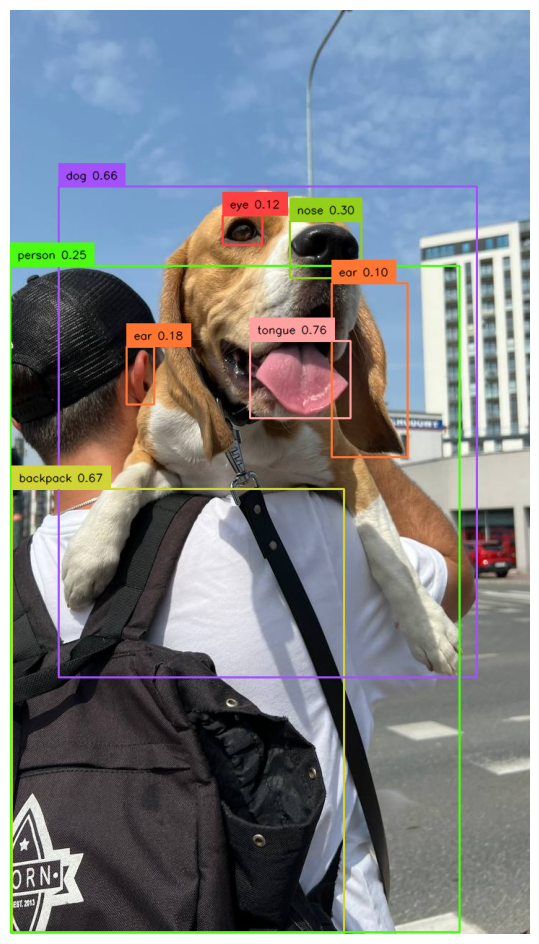

In [ ]:
image = run_image(runner, cv2.imread('/content/YOLO-World/dog.jpeg') , class_names)
sv.plot_image(image)